# 任务二的思路和难点
### 思路：
- 统计论文作者，那肯定得读取data['authors']这列
- 把所有名字一统计，找出总量前10的人名就好了
### 难点：
- 思路很好理解，但是实际操作发现，论文作者往往是几个甚至几十个人名组成的字符串
- 而且里边包含，逗号、括号、双括号、and、所属机构名称等等，这就对提取人名产生了很大的影响
#### 解决方案
- 1、通过观察发现，人名不会出现在括号中（即，括号里一般是数字，或者机构名称），则字符串大体上可以等价于“名字+括号”的组合
- 2、所以把括号及其中的内容统一替换成“逗号”，因为之后便于使用“逗号”分割字符串。这里需要使用正则表达式替换括号及其中内容为逗号
- 3、还发现里边含有and（比如：Tom, Marry and Li Lei），所以把and也统一替换成“逗号”
- 4、通过大量观察，还发现做研究的歪果仁经常是父子一起研究，而且他们的名字还是一样的，仅以Jr（Jr:二世，比如查理二世，就是查理的儿子，或者老布什和小布什）表示
- 5、所以需要把",Jr","and Jr"等替换成全名，例如：Mark, Jr ==> Mark, Mark Jr; Mark and Jr ==> Mark, Mark Jr

In [1]:
# id              : arXivID,用于访问论文
# submitter       : 论文提交者
# authors         : 论文作者
# title           : 论文标题
# comments        : 论文页数和图标等其它信息
# journal-ref     : 论文发表的期刊的信息
# doi             : 数字对象标识符
# report-no       : 报告编号
# categories      : 论文在arXiv系统的所属类别标签
# license         : 文章的许可证
# abstract        : 摘要
# versions        : 论文版本
# authors_parsed  : 作者信息

# BaseLine
# 任务1:论文数量统计（统计2019年全年，计算机各个方向论文的数量）
# 任务2:论文作者统计（统计所有论文作者出现频率Top10的姓名）
# 任务3:论文代码统计（统计所有论文类别下包含源代码论文的比例）
# 任务4:论文分类（利用已有数据建模，对新论文进行类别分类）
# 任务5:作者关联（对论文作者关系进行建模，统计最常出现的作者关系）

In [14]:
# 先用这几个库，之后不够再加
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import re

In [15]:
# 设置绘图可以使用中文
font = {'family': 'MicroSoft YaHei',
        'weight': 'bold',
        'size': 20}
matplotlib.rc("font", **font)

In [3]:
# 读取数据
data = []
# 使用with语句优势：1.自动关闭文件句柄；2.自动显示（处理）文件读取数据异常
with open(r"D:\TianChi_DataSet\paper_set\arxiv-metadata-oai-2019.json", 'r') as f:
    for line in f:
        data.append(json.loads(line))
    data = pd.DataFrame(data)    # 将list变为dataframe格式，方便使用pandas进行分析
print(data.shape)   #显示数据大小

(170618, 14)


In [4]:
# 这里就不检查数据缺失啥的了（我比较懒...）
data.columns

Index(['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi',
       'report-no', 'categories', 'license', 'abstract', 'versions',
       'update_date', 'authors_parsed'],
      dtype='object')

In [5]:
# 这个函数集我毕生功力而写出的字符串处理函数
def name_list(s):
    str = s['authors']
    new_str = ''
    final_li = []
    tmp1 = 0
    tmp2 = 0
    # 优先处理一下含有“ and Jr”和“, Jr”的两种情况，因为这个会影响后边的处理
    if ' and Jr' in str:
        for i in range(len(str)-1, 1, -1):
            if str[i-6:i+1] == ' and Jr':
                tmp1 = i-7
                break
        for j in range(tmp1, 0, -1):
            if str[j-2: j] == ', ':
                tmp2 = j
        str = str+','+str[tmp2:tmp1+1]+' Jr'
    elif ', Jr' in str:
        for i in range(len(str)-1, 1, -1):
            if str[i-3:i+1] == ', Jr':
                tmp1 = i-4
                break
        for j in range(tmp1, 0, -1):
            if str[j-2: j] == ', ':
                tmp2 = j
        str = str+','+str[tmp2:tmp1+1]+' Jr'
    # 处理完上面的情况，就剩下含有括号的了
    # 接下来需要使用正则表达式识别出括号及括号中包含的这部分字符串，并且把他们替换成逗号，方便之后利用逗号分割字符串
    if '((' in str:
        for i in range(len(str) - 1, 1, -1):
            if str[i] == '(' and str[i - 1] == '(':
                new_str = str[0:i - 1].replace(' and ', ',')
                break
        # 正则匹配括号，\s\S是匹配任意字符
        new_s = re.sub(r'\([\s\S]*\)', ',', new_str).split(',')
        li = [i.strip() for i in new_s]
        # 经过上边的处理之后，又发现字符串中还可能含有“et al”（一篇高水平的论文一般不是一个人完成的，极有可能是一个团队，et al表示不一一列举）
        for i in li:
            if i != '' and 'et al' not in i:
                final_li.append(i)
    else:
        new_s = re.sub(r'\([\s\S]*\)', ',', str).replace(' and ', ',').split(',')
        li = [i.strip() for i in new_s]
        for i in li:
            if i != '' and 'et al' not in i:
                final_li.append(i)
    return final_li

In [6]:
# 在最右侧添加一列'authors_list'并赋值为0，用于存储每条数据识别出来的人名
data['authors_list']=0

In [7]:
# 把上边写好的函数应用到data中去
data['authors_list'] = data.apply(name_list, axis=1)

In [8]:
# 简单的看了一下，效果还不错，字符串全都变成单个的名字了
data['authors_list'][1002:1009]

1002                                  [S. Bahinipati]
1003                               [Andrew G. Ivanov]
1004    [Ting-Wai Chiu, Tung-Han Hsieh, Po-Kai Tseng]
1005                                   [D. S. Bailey]
1006                              [Hermann Kolanoski]
1007                                     [Dilip Jana]
1008                                    [B. Sciascia]
Name: authors_list, dtype: object

In [9]:
# 这里偶然发现下面这好用的东西，统计起来真的是省时省力
from collections import Counter
names = []
for i in data['authors_list']:
    names += i
top_ = Counter(names).most_common(10)

In [10]:
# 下面就是绘图了
top_X = [i[0] for i in top_]
top_Y = [i[1] for i in top_]

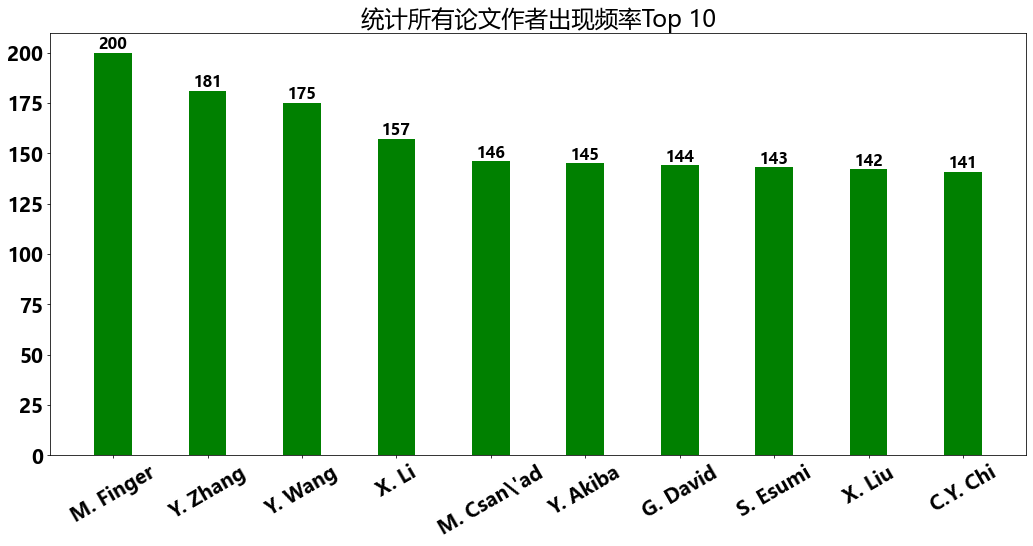

In [22]:
fig = plt.figure(figsize=(18, 8), dpi=70)
plt.bar(top_X,top_Y,0.4,color="green")
plt.xticks(top_X, top_X, rotation=30)

for a, b in zip(top_X, top_Y):
    plt.text(a, b + 0.07, '%.0f' % b, ha='center', va='bottom', fontsize=16)

plt.title("统计所有论文作者出现频率Top 10")

plt.show()